# LCSimulator

The LCSimulator is a simulation tool based on the SNCosmo python package version 2.1. This python notebook illustrates how the LCSimulator is used to generate multiply imaged SNIa lightcurves data. 

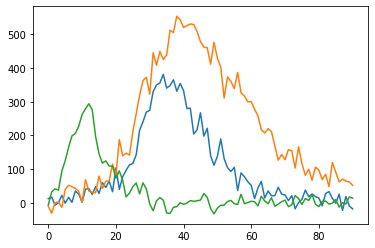

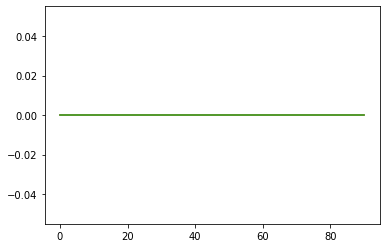

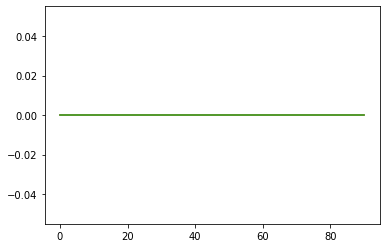

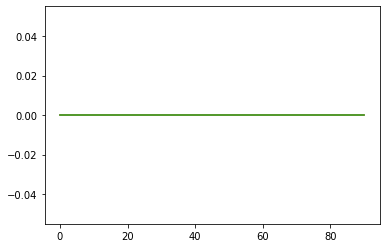

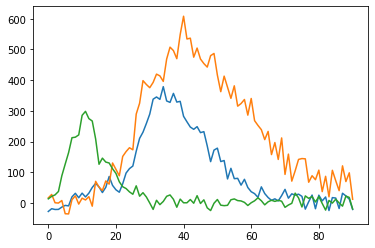

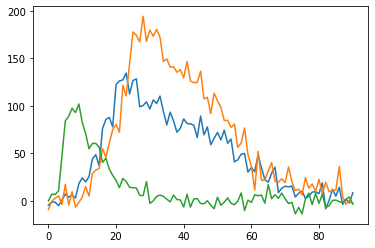

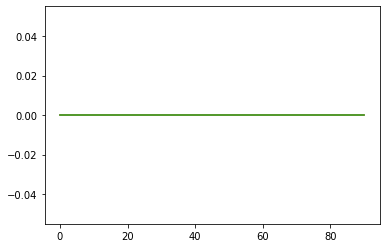

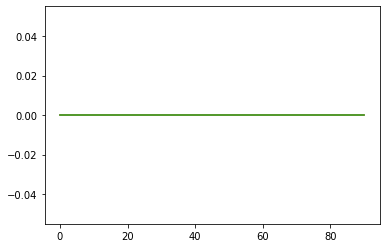

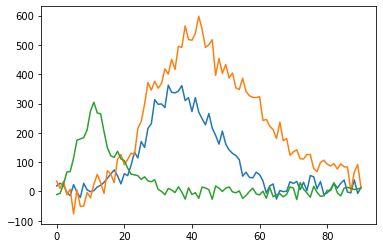

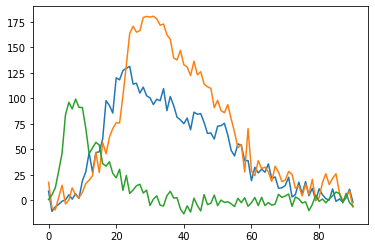

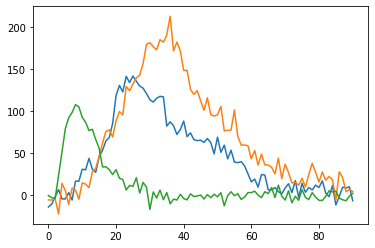

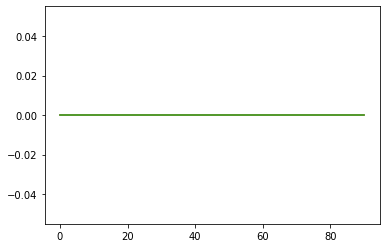

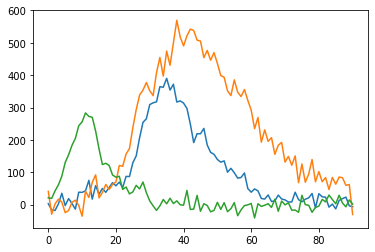

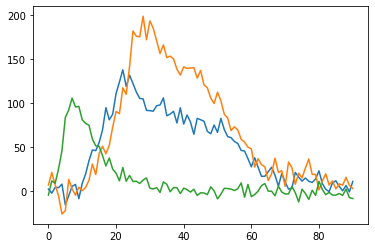

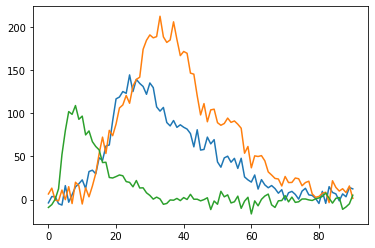

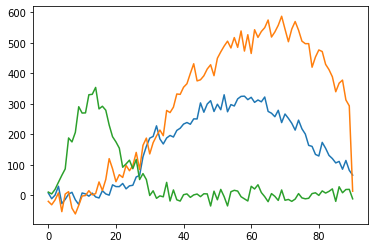

In [20]:
import sncosmo
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

printdata = False

nimagel = np.array([2, 1, 1, 4],int) # a sample of 4 systems with n_image = 2, 1, 1, 4 images 
nimage_max=np.max(nimagel)
Nsys=len(nimagel) 

t0 = 55000. #origin
dT = np.array([[0.00, 11.17, 0.00,  0.00],\
               [0.00,  0.00, 0.00,  0.00],\
               [0.00,  0.00, 0.00,  0.00],
               [0.00, 12.71, 23.23, 35.41]],float) # absolute (unobservable) times t_i: i=1,...,n_image

MU = np.array([[1.44,  2.09, 1.00,  1.00],\
               [1.14,  0.00, 0.00,  0.00],\
               [1.18,  0.00, 0.00,  0.00],
               [1.09,  1.35, 1.27,  1.30]],float) # magnifications mu_i: i=1,...,n_image


np.random.seed(202)

bands = ('ztfg','ztfr','ztfi')
nbands = len(bands)

nobs = [91,90,30] # total number of observations in g,r,i bands
nobs_max = max(nobs)

dnobs=[1,1,4]
ddnobs=[0.8,0.8,1.2]

obs = -1*np.ones((nbands,nobs_max))

pers=5.0/100 #noise level: dafault is 5% the maximum flux

seedsn=np.random.randint(0,100000,Nsys)

#Flux per image per band per system 
imfluxes = np.zeros((Nsys,nimage_max,nbands,nobs_max))
#Flux summed over images
Fluxes = np.zeros((Nsys,nbands,nobs_max))
#Additive noise in summed fluxes
Noises = np.zeros((Nsys,nbands,nobs_max))
    
for sys in range(Nsys):

    np.random.seed(seedsn[sys])
    model = sncosmo.Model(source='hsiao')
    model.set(z=0.4, t0=t0, amplitude=1.e-4)
    
    for j in range(nbands):
        #observation times
        obsv = np.random.poisson(dnobs[j],size=nobs[j])+ddnobs[j]
        for ii in range(1,nobs[j]):
            obsv[ii]=obsv[ii-1]+obsv[ii]
        obs[j,:nobs[j]]= obsv + 54965

        for i in range(nimagel[sys]):
            #individual image fluxes
            imfluxes[sys,i,j,:nobs[j]] = MU[sys,i]*model.bandflux(bands[j], obs[j,:nobs[j]]-dT[sys,i])

    Fluxes = np.sum(imfluxes,axis=1) #Total flux w/o noise 

    for j in range(nbands):
        Noises[sys,j,:] = np.full(nobs_max,pers*np.max(Fluxes[sys,j,:])) #errors
        Noise=np.random.normal(0,Noises)
    
    #Total flux w/ noise
    NFluxes = Fluxes + Noise

    if printdata:
        
        print('# System:',sys+1)
        print('# Number of images in the system =',nimagel[sys])
        if nimagel[sys]==1:
            dt = 0
            mu = 1
        elif nimagel[sys]==2:
            dt = dT[sys,1]-dT[sys,0]
            mu = MU[sys,1]/MU[sys,0]
        else:
            dt = dT[sys,1:]-dT[sys,0:3]
            mu = MU[sys,1:]/MU[sys,0]            
        print('# Consequitive time delays dt_i:', dt)
        print('# Magnification ratios, mu_i1:', mu) 
        for j in range(nbands):
            print('# '+bands[j]+' data: obs, total, image_1, image_2, image_3, image_4 ')
            for k in range(nobs[j]):
                print(f'{k+1:3d} {obs[j,k]:7.1f} {NFluxes[sys,j,k]:15.5e} {Noises[sys,j,k]:15.5e}'\
                     +f'{imfluxes[sys,0,j,k]:15.5e} {imfluxes[sys,1,j,k]:15.5e}'\
                     +f'{imfluxes[sys,2,j,k]:15.5e} {imfluxes[sys,3,j,k]:15.5e}')
